In [1]:
import glob
import importlib
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import MDAnalysis as mda
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import seaborn as sns
from matplotlib import ticker
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

import extq
import ivac

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
sys.path.insert(1, "../../python")
import plotting
import util

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [5]:
from joblib import Parallel, delayed
from multiprocess import cpu_count

n_jobs = cpu_count()

# to lipids

In [6]:
u = mda.Universe("../../civsd-nowat.pdb", "../../anton2/nowat/civsd.nowat.3.dcd")

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


## Parallel calculations

In [7]:
HOME_DIR = "/project/dinner/scguo/ci-vsd"

In [8]:
def hbond_anton(trajfile, r_i, cutoff=3.4, angle=90):
    u = mda.Universe(f"{HOME_DIR}/civsd-nowat.pdb", trajfile)
    r_sel = f"protein and resid {r_i} and not backbone and type N"
    phos_sel = f"name O11 O12 O13 O14 and around {cutoff} (protein and resid {r_i})"
    h_sel = f"protein and resid {r_i} and name HE HH11 HH21 HH22 HH12"
    hbonds = HydrogenBondAnalysis(
        universe=u,
        donors_sel=r_sel,
        hydrogens_sel=h_sel,
        acceptors_sel=phos_sel,
        update_selections=True,
        d_a_cutoff=cutoff,
        d_h_a_angle_cutoff=angle,
    )
    return hbonds


def run_analysis(analysis):
    analysis.run()
    return analysis.count_by_time()

In [9]:
dcds = []
for i in range(3, 119):
    if i == 82:
        continue
    dcds.append(f"{HOME_DIR}/anton2/nowat/civsd.nowat.{i}.dcd")
print(len(dcds))

115


In [10]:
def compute_hb_cutoff_angle(r_i, files, cutoff, angle, n_jobs=40, verbose=10):
    analysis_ensemble = [hbond_anton(f, r_i, cutoff=cutoff, angle=angle) for f in files]
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(run_analysis)(analysis) for analysis in analysis_ensemble
    )
    return results

In [ ]:
cutoffs = [3.1, 3.2, 3.3, 3.4, 3.5]
angles = [90, 100, 110, 120, 130]
scan_results_r232 = {}
for c in cutoffs:
    for a in angles:
        print(f"Computing hydrogen bonds with cutoff {c} and angle {a}")
        result = compute_hb_cutoff_angle(232, dcds, c, a, n_jobs=n_jobs, verbose=10)
        scan_results_r232[(c, a)] = result

Computing hydrogen bonds with cutoff 3.1 and angle 90


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

Text(0.5, 0, 'R232-lipid hydrogen bonds')

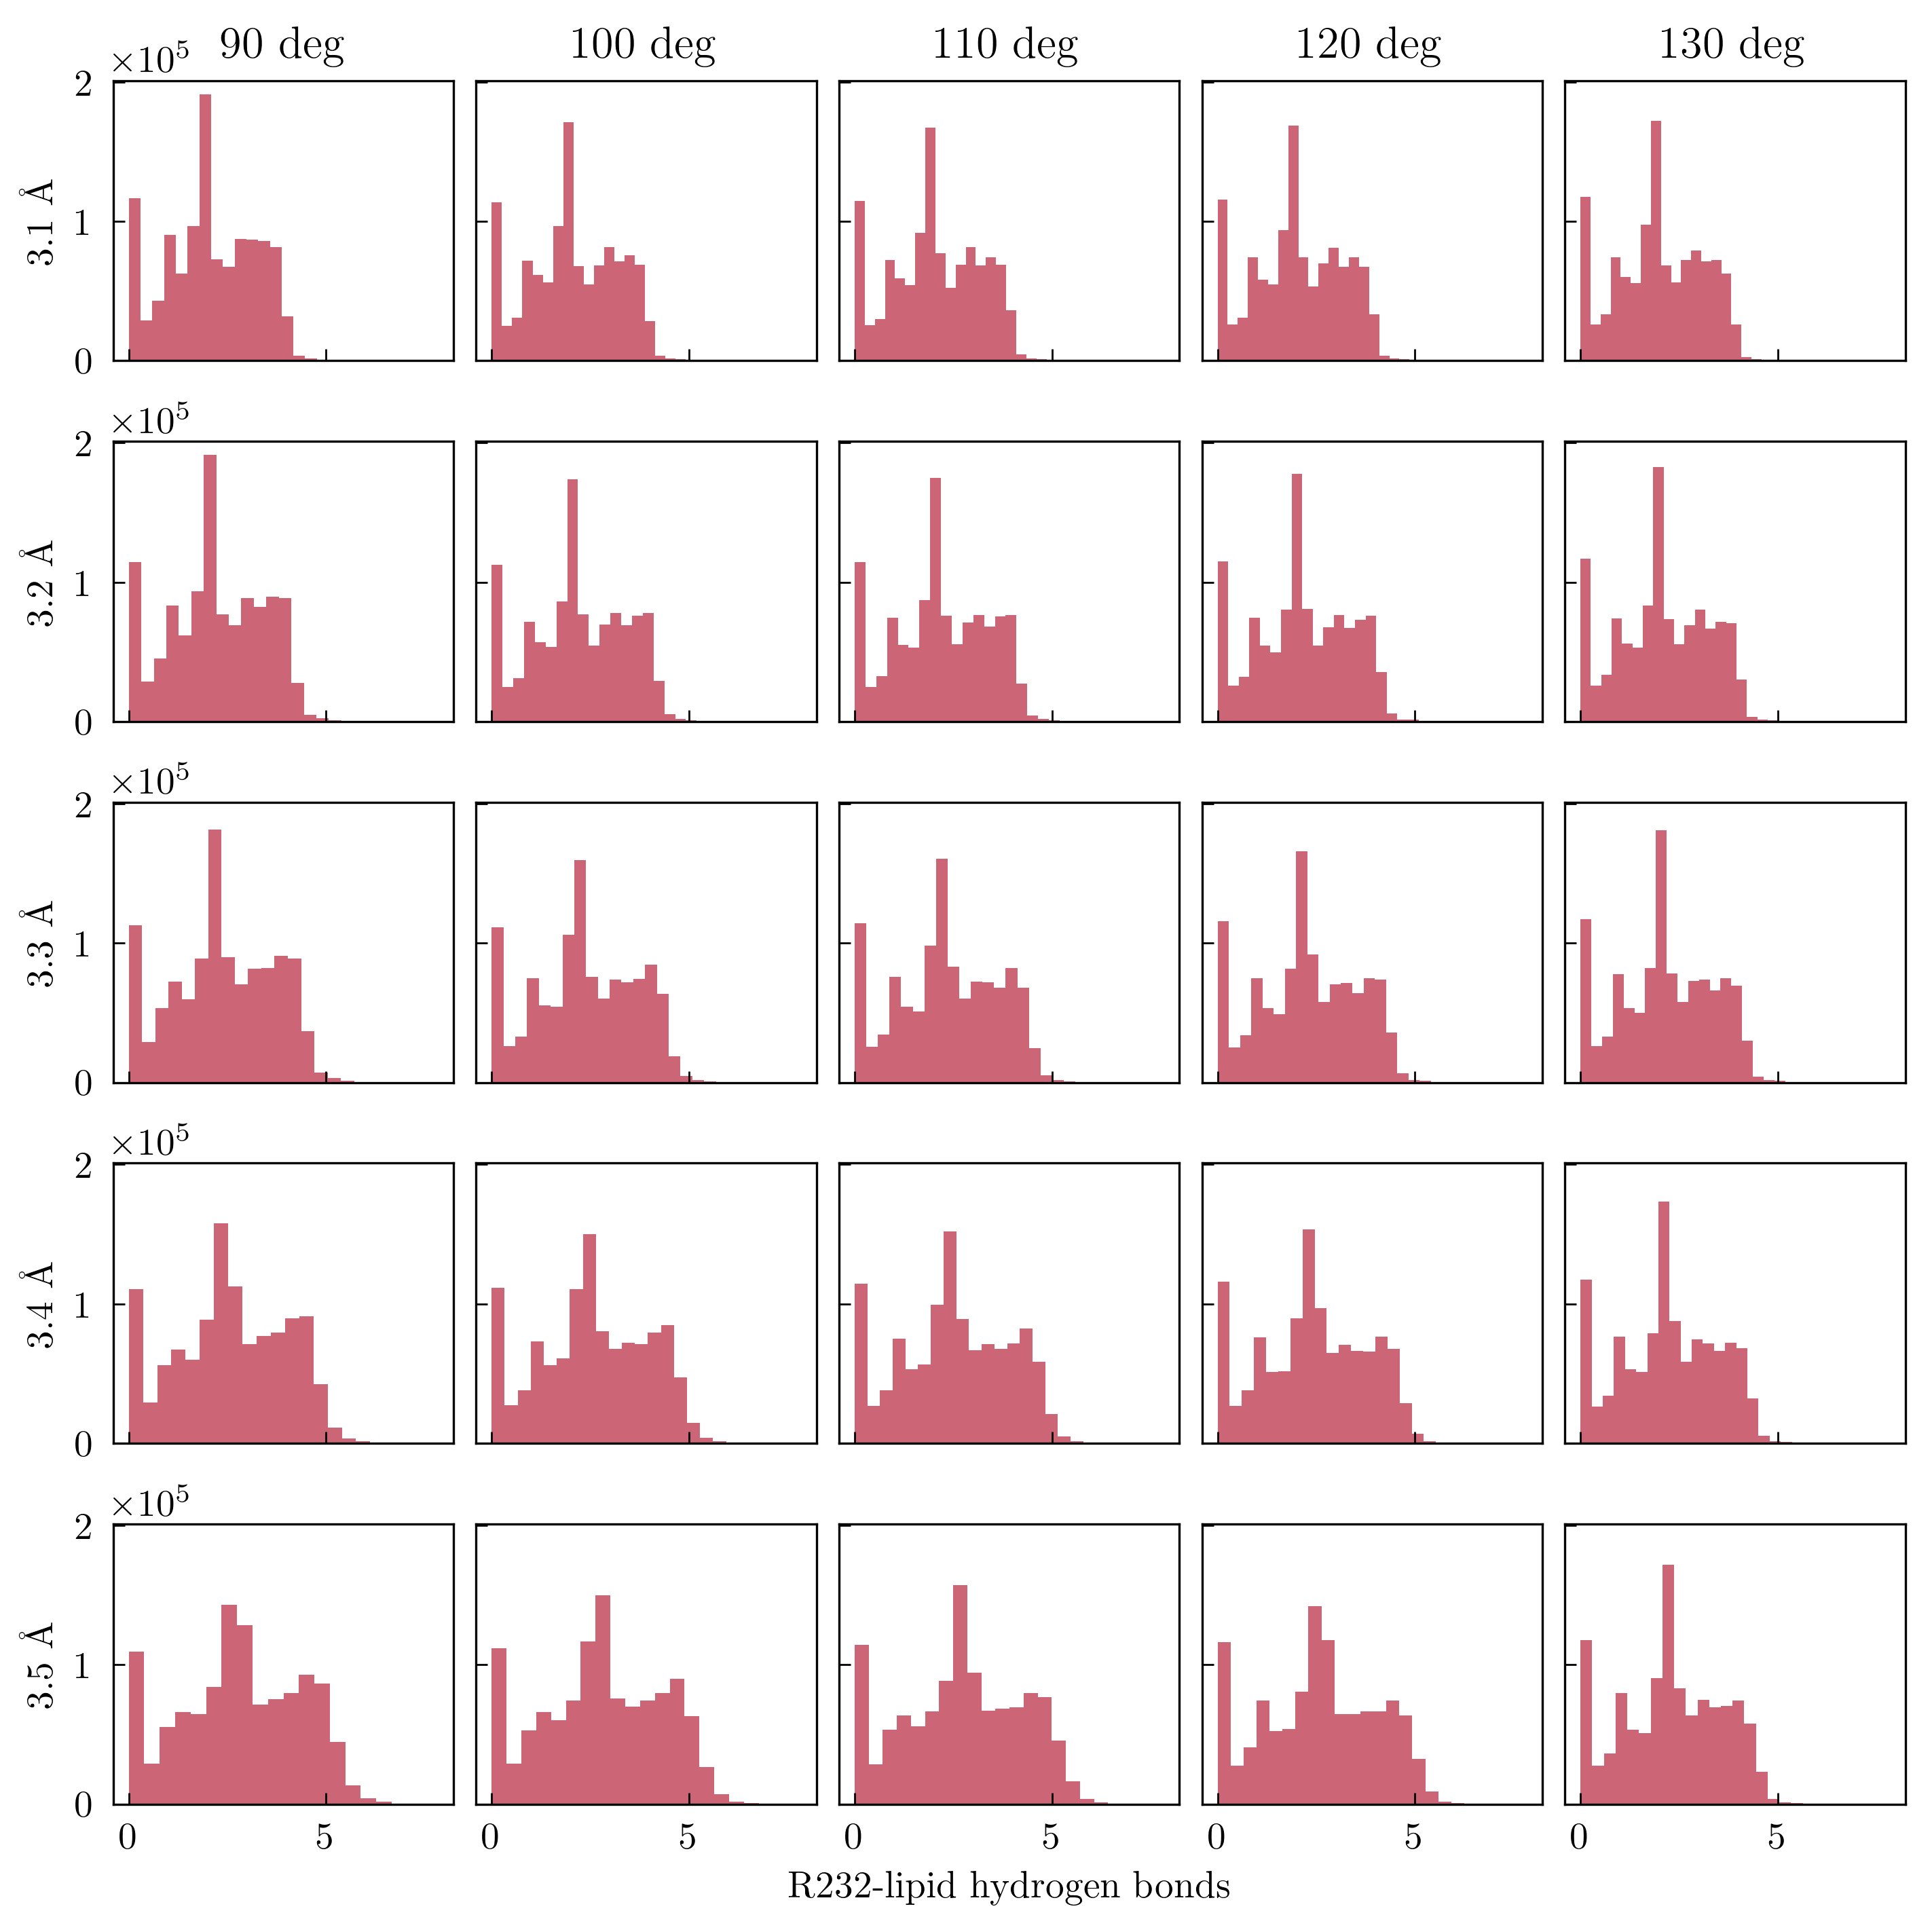

In [13]:
f, axs = plt.subplots(
    len(cutoffs),
    len(angles),
    figsize=(7, 7),
    dpi=200,
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
for i, c in enumerate(cutoffs):
    for j, a in enumerate(angles):
        ax = axs[i, j]
        data = list(scan_results_r232[(c, a)])
        smoothed = util.smooth_moving_average(data, 10)
        ax.hist(np.concatenate(smoothed), bins=20)
for i, c in enumerate(cutoffs):
    axs[i, 0].set_ylabel(f"{c} Å")
for j, a in enumerate(angles):
    axs[0, j].set_title(f"{a} deg")
axs[-1, 2].set_xlabel("R232-lipid hydrogen bonds")

In [11]:
# load committors and weights
import h5py

In [12]:
f = h5py.File("../../data/feat2_dist_du_anton2/feat2_dist_anton2.h5", mode="r")
q = f["y"][3_000_000:]
weights = f["weights"][3_000_000:]

In [13]:
q = np.split(q, 115)
weights = np.split(weights, 115)

Text(0.5, 0, 'R232-lipid hydrogen bonds')

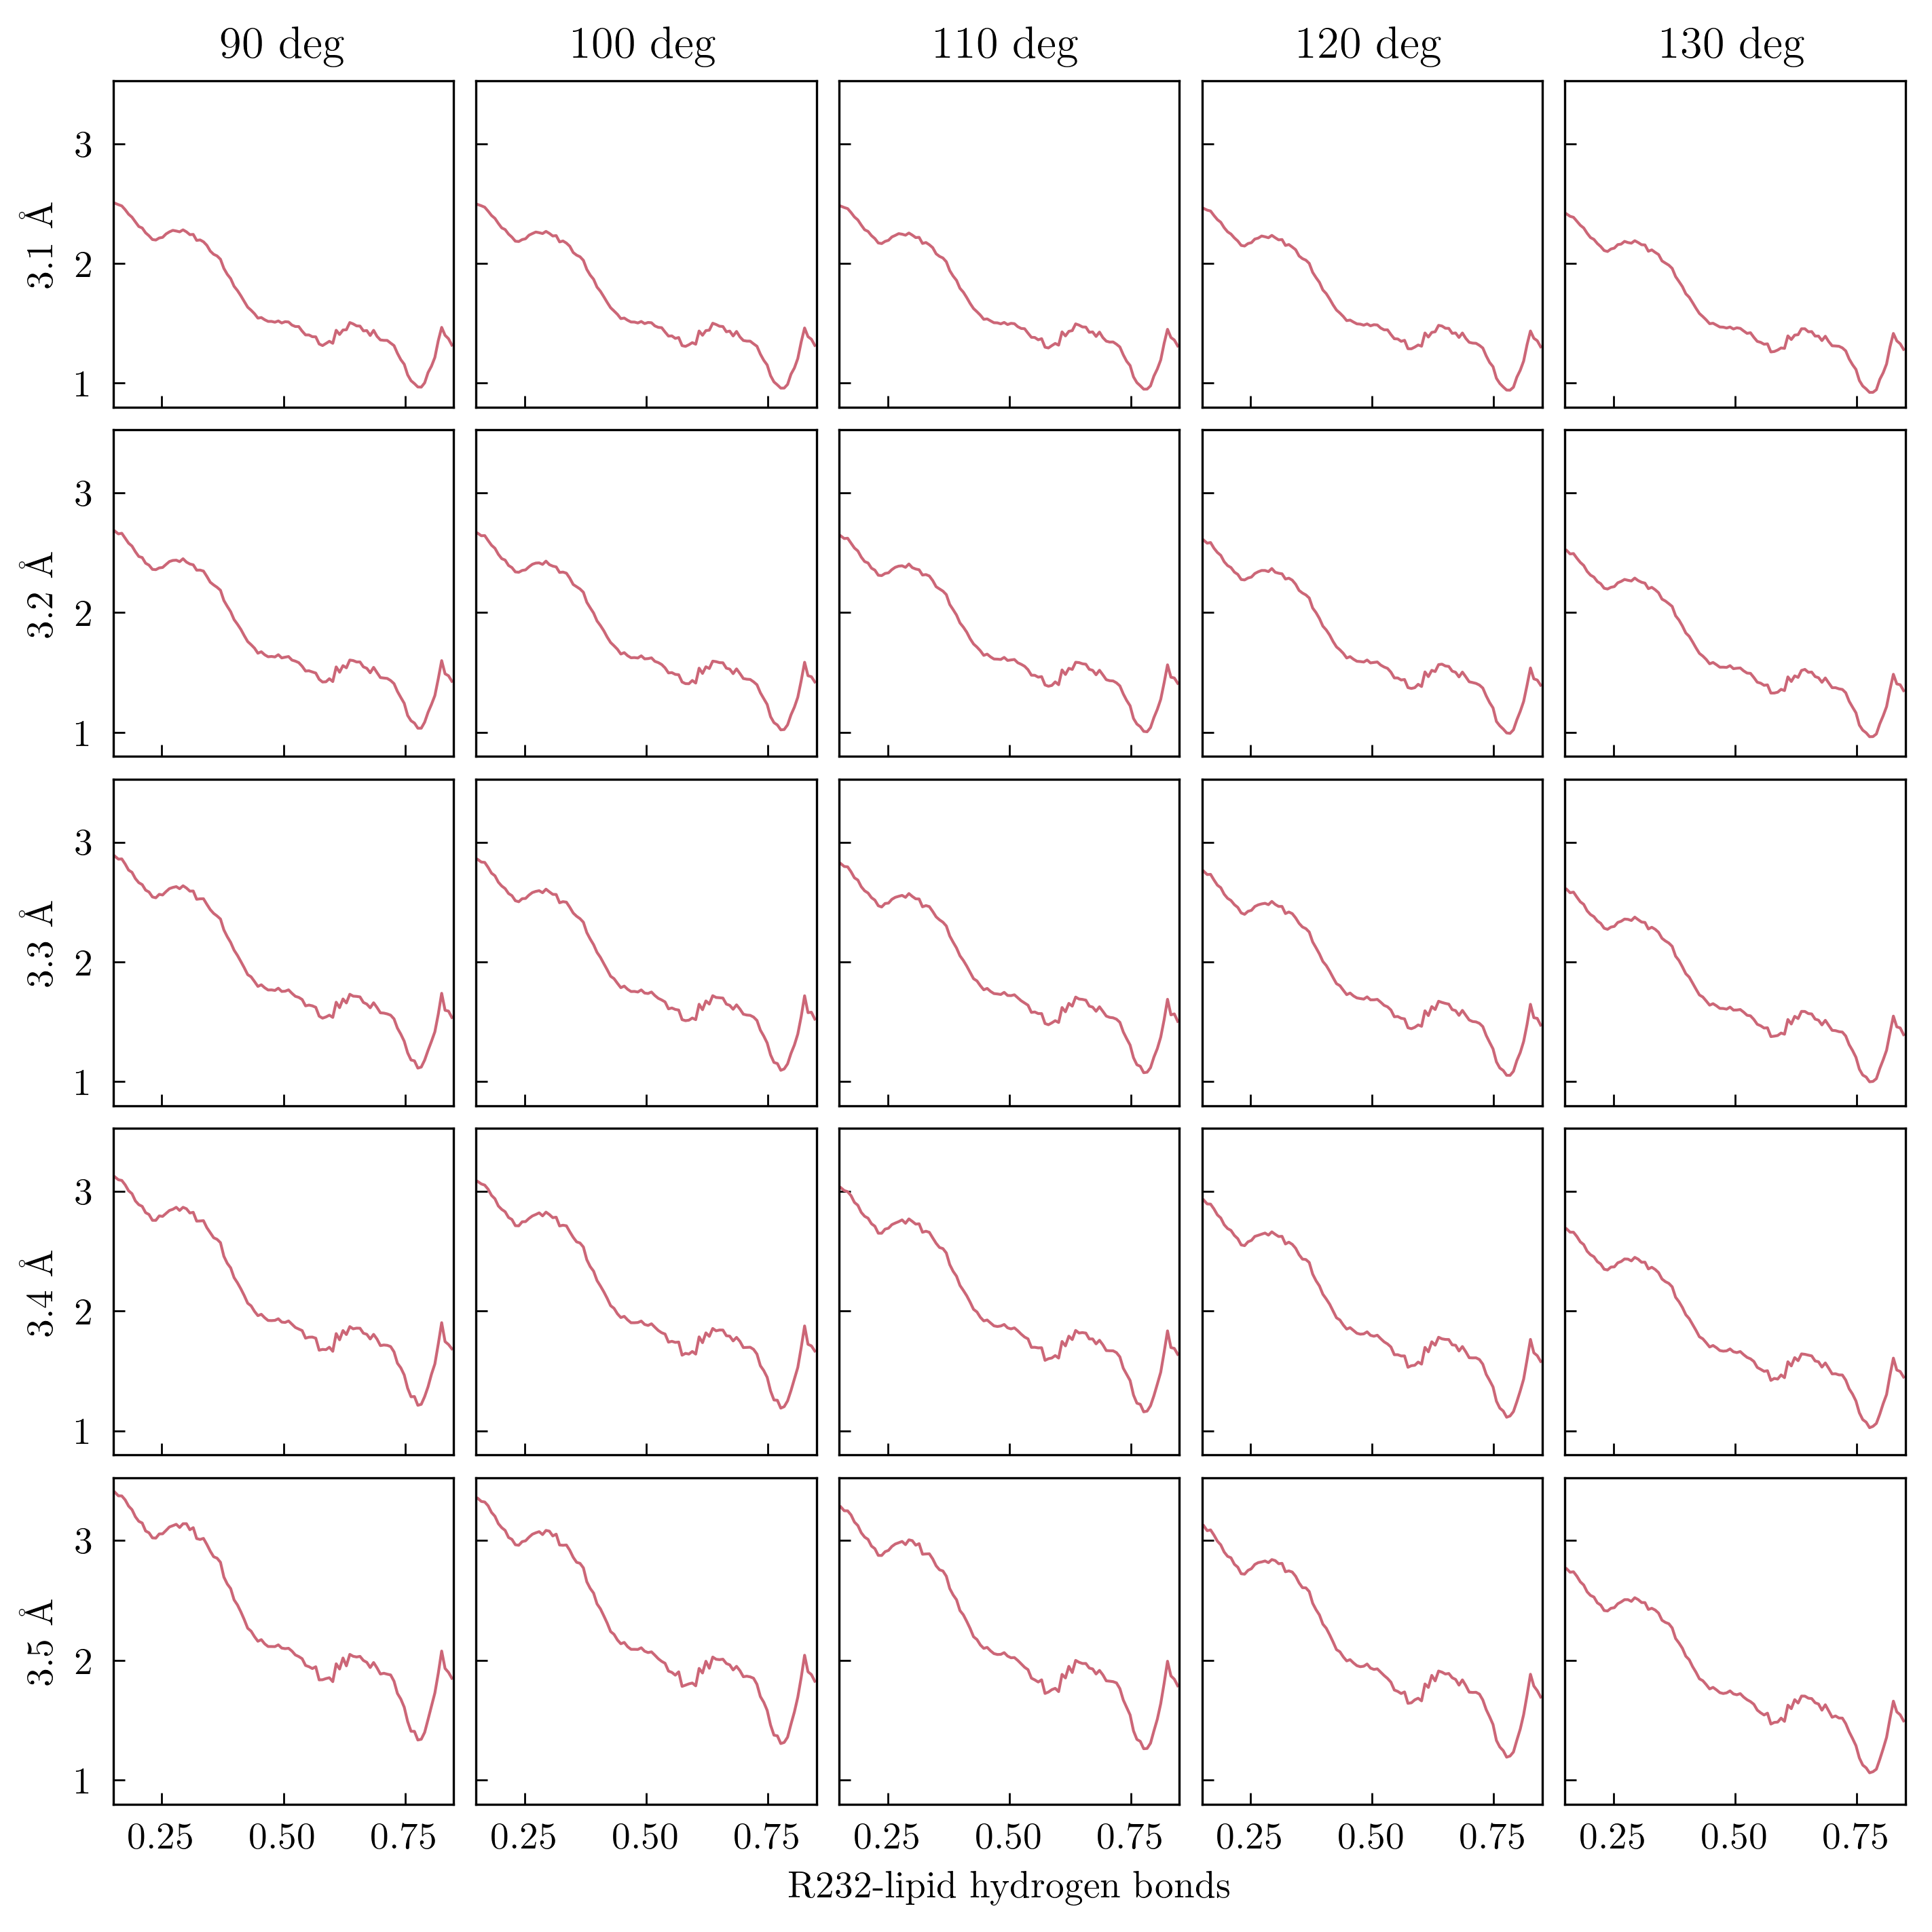

In [20]:
lo, hi = 0.15, 0.85
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

f, axs = plt.subplots(
    len(cutoffs),
    len(angles),
    figsize=(7, 7),
    dpi=200,
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
for i, c in enumerate(cutoffs):
    for j, a in enumerate(angles):
        ax = axs[i, j]
        data = list(scan_results_r232[(c, a)])
        q_hist = extq.projection.average1d(q, data, weights, qe)
        ax.plot(qc, q_hist)
        ax.set_xlim([lo, hi])
for i, c in enumerate(cutoffs):
    axs[i, 0].set_ylabel(f"{c} Å")
for j, a in enumerate(angles):
    axs[0, j].set_title(f"{a} deg")
axs[-1, 2].set_xlabel("R232-lipid hydrogen bonds")

**choose 3.5 Å and 120 deg for round numbers**

# to water

In [14]:
topfile = "/project/dinner/scguo/ci-vsd/models/MD-clustering-center/civsd.psf"

In [15]:
def hbond_anton_water(startfile, trajfile, r_i, cutoff=3.4, angle=90):
    u = mda.Universe(startfile)
    u = u.load_new(trajfile)
    r_sel = f"protein and resid {r_i} and not backbone and name NE NH1 NH2"
    wat_sel = f"name OH2 and around {cutoff} (protein and resid {r_i})"
    h_sel = f"protein and resid {r_i} and name HE HH11 HH21 HH22 HH12"
    hbonds = HydrogenBondAnalysis(
        universe=u,
        donors_sel=r_sel,
        hydrogens_sel=h_sel,
        acceptors_sel=wat_sel,
        update_selections=True,
        d_a_cutoff=cutoff,
        d_h_a_angle_cutoff=angle,
    )
    return hbonds

In [16]:
def compute_hydration_cutoff_angle(
    r_i, startfiles, trajfiles, cutoff, angle, n_jobs=40, verbose=10
):
    analysis_ensemble = [
        hbond_anton_water(sf, tf, r_i, cutoff=cutoff, angle=angle)
        for (sf, tf) in zip(startfiles, trajfiles)
    ]
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(run_analysis)(analysis) for analysis in analysis_ensemble
    )
    return results

In [17]:
water_dcds = []
water_startfiles = []
for i in range(3, 119):
    if i == 82:
        continue
    water_dcds.append(f"/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.{i}.dcd")
    dmsfiles = glob.glob(f"/beagle3/dinner/scguo/anton2-backup/workdir.{i}/*.dms")
    k = ""
    for f in dmsfiles:
        if not "groups" in f:
            k = f
    water_startfiles.append(k)
print(len(water_dcds))
print(len(water_startfiles))

115
115


In [17]:
analysis_ensemble = [
    hbond_anton_water(sf, tf, 127, cutoff=3.5, angle=120)
    for (sf, tf) in zip(water_startfiles, water_dcds)
]

In [20]:
analysis_ensemble[1].u.trajectory

<DCDReader /beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.4.dcd with 10000 frames of 56582 atoms>

In [37]:
# u = mda.Universe(water_startfiles[1])
u = mda.Universe(topfile, water_dcds[1])
# u = u.load_new(water_dcds[1])
print(u.trajectory)

<DCDReader /beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.4.dcd with 10000 frames of 56582 atoms>


In [40]:
# u = mda.Universe(water_startfiles[0])
# u = u.load_new(water_dcds[0])
u = mda.Universe(topfile, water_dcds[0])
print(u.trajectory)

<DCDReader /beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.3.dcd with 10001 frames of 56582 atoms>


In [41]:
scan_results_r232_water = {}
cutoffs = [3.5]
angles = [120]
for c in cutoffs:
    for a in angles:
        print(f"Computing hydrogen bonds with cutoff {c} and angle {a}")
        # the dms file topology is numbered from 0 (offset of 105 residues)
        result = compute_hydration_cutoff_angle(
            127, water_startfiles, water_dcds, c, a, n_jobs=n_jobs, verbose=10
        )
        scan_results_r232_water[(c, a)] = result

Computing hydrogen bonds with cutoff 3.5 and angle 120


KeyboardInterrupt: 

Text(0.5, 0, 'R232-water hydrogen bonds')

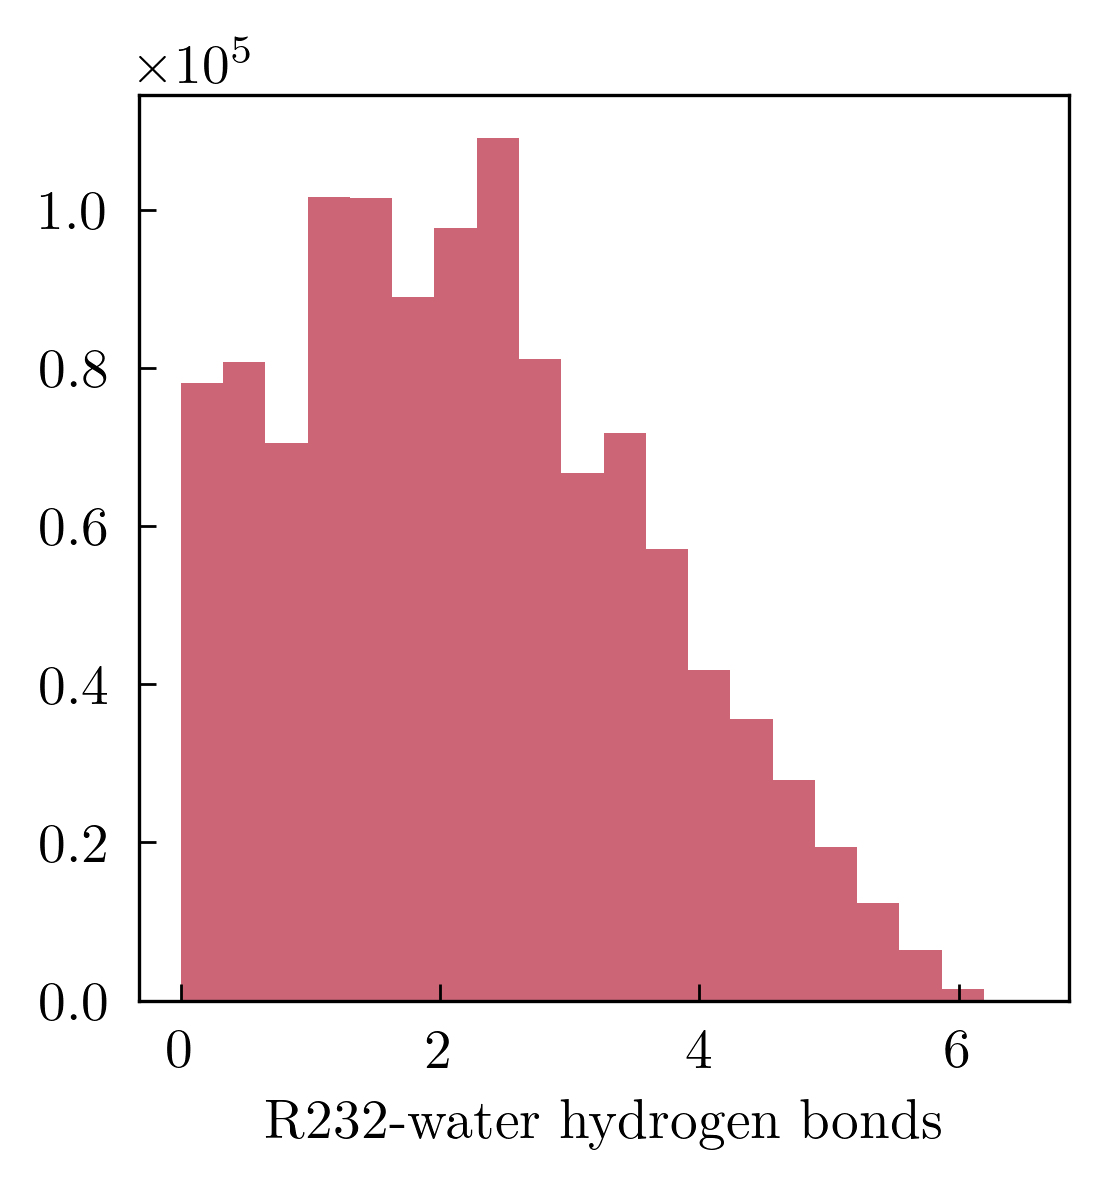

In [16]:
f = plt.figure(figsize=(3, 3), dpi=200)
ax = plt.gca()
data = list(scan_results_r232_water[(3.5, 120)])
smoothed = util.smooth_moving_average(data, 10)
ax.hist(np.concatenate(smoothed), bins=20)
ax.set_xlabel("R232-water hydrogen bonds")

In [ ]:
f, axs = plt.subplots(
    len(cutoffs),
    len(angles),
    figsize=(7, 7),
    dpi=200,
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
for i, c in enumerate(cutoffs):
    for j, a in enumerate(angles):
        ax = axs[i, j]
        data = list(scan_results_r232_water[(c, a)])
        smoothed = util.smooth_moving_average(data, 10)
        ax.hist(np.concatenate(smoothed), bins=20)
for i, c in enumerate(cutoffs):
    axs[i, 0].set_ylabel(f"{c} Å")
for j, a in enumerate(angles):
    axs[0, j].set_title(f"{a} deg")
axs[-1, 2].set_xlabel("R232-water hydrogen bonds")

## all arginines

In [18]:
results = []
c = 3.5
a = 120
for r_i in (112, 118, 121, 124, 127):
    print(f"Computing hydrogen bonds with cutoff {c} and angle {a}")
    # the dms file topology is numbered from 0 (offset of 105 residues)
    result = compute_hydration_cutoff_angle(
        r_i, water_startfiles, water_dcds, c, a, n_jobs=n_jobs, verbose=10
    )
    results.append(result)

Computing hydrogen bonds with cutoff 3.5 and angle 120


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils V

Computing hydrogen bonds with cutoff 3.5 and angle 120


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

Computing hydrogen bonds with cutoff 3.5 and angle 120


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` na

Computing hydrogen bonds with cutoff 3.5 and angle 120


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

Computing hydrogen bonds with cutoff 3.5 and angle 120


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` na

## first frames

In [19]:
new_results = np.empty((115, 5, 10001))
counter = 0
for i in range(3, 119):
    if i == 82:
        continue
    files = glob.glob(f"/beagle3/dinner/scguo/anton2-backup/workdir.{i}/*.dms")
    k = ""
    for f in files:
        if not "groups" in f:
            k = f
    for j, r_i in enumerate((112, 118, 121, 124, 127)):
        u = mda.Universe(k)
        r_sel = f"protein and resid {r_i} and not backbone and name NE NH1 NH2"
        wat_sel = f"name OH2 and around 3.0 (protein and resid {r_i})"
        h_sel = f"protein and resid {r_i} and name HE HH11 HH21 HH22 HH12"
        hbonds = HydrogenBondAnalysis(
            universe=u,
            donors_sel=r_sel,
            hydrogens_sel=h_sel,
            acceptors_sel=wat_sel,
            update_selections=True,
            d_a_cutoff=c,
            d_h_a_angle_cutoff=a,
        )
        hbonds.run()
        
        new_results[counter, j, 0] = hbonds.count_by_time()
    counter += 1

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [20]:
for i in range(115):
    for j, result in enumerate(results):
        new_results[i, j, 1:] = result[i][-10000:]

In [21]:
new_results.shape

(115, 5, 10001)

In [25]:
np.save("../../data/raw_feat/hbond_water_anton2.npy", np.reshape(new_results, (115, -1, 5)))

In [24]:
np.load("../../data/raw_feat/hbond_water_0-179.npy").shape

(179, 10000, 5)